# YASA

This notebook demonstrates how to use YASA to perform **multi-channels sleep spindles detection** from a NumPy array (example 1) or a MNE Raw object (example 2).

Please make sure to install YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

**Important**
- The data must be a numpy array of shape *(n_channels, n_samples)*.
- The sampling frequency `sf` must be the same for all channels.
- A list of the channel names (`ch_names`) must be provided as well.
- The unit of the data must be $\mu V$. Note that the default unit in [MNE](https://martinos.org/mne/dev/generated/mne.io.Raw.html) is $V$. Therefore, if you use MNE, you must multiply your data by 1e6 (1 $V$ = 1,000,000 $\mu V$).

## Example 1: Using NumPy

To illustrate the multi-channel spindles detection, we load a full-night 3-channels dataset (Cz, Fz, Pz) sampled at 100 Hz. The data is in compressed NumPy format (*.npz*).

In [1]:
import yasa
import numpy as np

# Load data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, chan = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

print(data.shape, chan)
print(np.round(data[:, 0:5], 3))

(3, 2161058) ['Cz' 'Fz' 'Pz']
[[15.797 22.307 39.922 25.657 27.094]
 [16.896 26.385 40.966 21.833 24.456]
 [ 5.899 14.297 36.592 26.094 23.395]]


*************

**Applying the detection**

To apply the multi-channel detection, we use the [spindles_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect.html#yasa.spindles_detect) function:

In [2]:
sp = yasa.spindles_detect(data, sf, ch_names=chan, multi_only=False)
all_spindles = sp.summary()  # Get the full detection dataframe
all_spindles

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,522.54,522.78,523.79,1.25,45.509445,10.850299,2.131626,0.470228,13.082397,16.0,0.190476,Cz,0
1,585.51,586.09,586.38,0.87,59.435380,13.185339,2.255297,0.473192,12.945464,11.0,0.659091,Cz,0
2,598.06,598.62,599.54,1.48,79.922226,15.976502,2.373750,0.421111,12.889143,19.0,0.375839,Cz,0
3,604.36,604.73,605.12,0.76,60.648920,12.520378,2.210118,0.350348,12.645687,9.0,0.480519,Cz,0
4,607.53,607.98,608.05,0.52,50.211401,13.846638,2.357938,0.258203,13.449947,6.0,0.849057,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,20498.20,20498.74,20499.22,1.02,83.897639,19.548310,2.609572,0.515605,12.320190,12.0,0.524272,Pz,2
1915,20512.68,20512.95,20513.42,0.74,55.426790,11.739013,2.243399,0.355705,13.187207,10.0,0.360000,Pz,2
1916,20524.99,20525.30,20525.61,0.62,66.723038,17.171995,2.614124,0.302493,12.776808,7.0,0.492063,Pz,2
1917,20542.93,20543.36,20544.65,1.72,78.694386,14.282672,2.103757,0.287887,12.486788,20.0,0.248555,Pz,2


Using the ``.summary()`` method, we can easily extract the number of spindles detected per channel, as well as the mean spindles properties per channel:

In [3]:
sp.summary(grp_chan=True, aggfunc='mean')

,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
Cz,671,1.039523,78.635978,17.153597,2.427569,0.403704,12.655373,12.840537,0.519055
Fz,552,0.986123,70.917785,15.491381,2.327937,0.382321,12.485471,12.021739,0.516569
Pz,696,1.037328,71.007709,15.400215,2.326347,0.396091,12.663334,12.821839,0.512108


If needed, we can also extract a "mask" array that has the same size as data where samples that are part of a detected spindles are marked as 1 (and all other are set to zero). This is useful for plotting.

In [4]:
mask = sp.get_mask()
print(mask.sum(1))
print(mask)

[70524 55058 73015]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Finally, we can also plot an average template of all detected spindles:

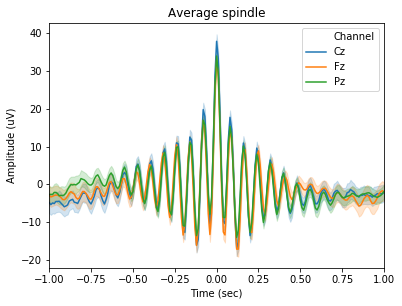

In [5]:
sp.plot_average(center='Peak', time_before=1, time_after=1)

### Find spindles that are present on at least two channels

Using the `multi_only=True` argument, we force the detection to keep only the spindles that are present on at least two different channels. Spindles are considered the same if their start or end times fall within the same second. In other words, start and end times are rounded to the nearest integer and compared across channels.

In [6]:
sp_multi = yasa.spindles_detect(data, sf, ch_names=chan, multi_only=True, remove_outliers=True)
all_spindles = sp_multi.summary()
print(all_spindles.shape[0], 'spindles detected that are common to at least two electrodes.')
all_spindles.head().round(3)

1245 spindles detected that are common to at least two electrodes.


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,585.51,586.09,586.38,0.87,59.435,13.185,2.255,0.473,12.945,11.0,0.659,Cz,0
1,598.06,598.62,599.54,1.48,79.922,15.977,2.374,0.421,12.889,19.0,0.376,Cz,0
2,604.36,604.73,605.12,0.76,60.649,12.520,2.210,0.350,12.646,9.0,0.481,Cz,0
3,655.06,655.50,655.88,0.82,47.596,10.832,2.149,0.369,13.297,11.0,0.530,Cz,0
4,725.60,726.50,726.88,1.28,77.591,18.836,2.371,0.288,12.368,15.0,0.698,Cz,0


In [7]:
sp.summary(grp_chan=True)

,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
Cz,671,1.039523,78.635978,17.153597,2.427569,0.403704,12.655373,12.840537,0.519055
Fz,552,0.986123,70.917785,15.491381,2.327937,0.382321,12.485471,12.021739,0.516569
Pz,696,1.037328,71.007709,15.400215,2.326347,0.396091,12.663334,12.821839,0.512108


### Find spindles that are present on ALL channels only

The code below show how to apply an even more stringent selection: only the spindles that are common across all electrodes are kept. This method is not natively implemented in YASA as it is certainly too restrictive when data has one or more tens of channels.

In [8]:
from functools import reduce
grp_start = all_spindles.groupby('Channel')['Start'].apply(lambda x: list(np.round(x).astype(int))).to_dict()
grp_end = all_spindles.groupby('Channel')['End'].apply(lambda x: list(np.round(x).astype(int))).to_dict()

intersect_start = reduce(np.intersect1d, (grp_start[c] for c in all_spindles['Channel'].unique()))
intersect_end = reduce(np.intersect1d, (grp_end[c] for c in all_spindles['Channel'].unique()))

idx_start = np.in1d(all_spindles['Start'].round().astype(int), intersect_start)
idx_end = np.in1d(all_spindles['End'].round().astype(int), intersect_end)
idx_good = np.logical_or(idx_start, idx_end)

# Now we keep only these spindles in the dataframe
print(all_spindles[idx_good].shape[0], 'unique spindles are common across ALL channels.')
all_spindles[idx_good].head().round(3)

705 unique spindles are common across ALL channels.


,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
2,604.36,604.73,605.12,0.76,60.649,12.520,2.210,0.350,12.646,9.0,0.481,Cz,0
5,735.12,735.90,736.39,1.27,80.165,16.962,2.544,0.579,12.672,15.0,0.609,Cz,0
6,744.01,744.98,745.47,1.46,79.723,16.769,2.603,0.636,12.774,19.0,0.660,Cz,0
9,1321.01,1321.76,1322.28,1.27,98.536,21.469,2.546,0.299,12.360,16.0,0.586,Cz,0
11,1364.50,1365.71,1366.22,1.72,71.419,15.509,2.284,0.436,12.870,21.0,0.699,Cz,0


### Test with a bad channel

Here, we create a fake channel with no spindle to test the detection.

In [9]:
data[1, :] = np.sin(0.1 * np.arange(data.shape[1]))
sp_bad = yasa.spindles_detect(data, sf, ch_names=chan, multi_only=False)
sp_bad.summary(grp_chan=True)

07-May-20 23:24:37 | WARNING | No spindle were found in channel Fz.


,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
Cz,671,1.039523,78.635978,17.153597,2.427569,0.403704,12.655373,12.840537,0.519055
Pz,696,1.037328,71.007709,15.400215,2.326347,0.396091,12.663334,12.821839,0.512108


In [10]:
# Check that no events were marked as spindles on the second (bad) channel
mask = sp_bad.get_mask()
mask.sum(1)

array([70524,     0, 73015])

**************

## Example 2: Using a Raw object from MNE-Python

This example demonstrates how to manipulate [MNE Raw object](https://mne-tools.github.io/stable/generated/mne.io.Raw.html#mne.io.Raw). The MNE package has several [functions](https://mne-tools.github.io/stable/python_reference.html#module-mne.io) to load the most standard EEG file formats (EDF, BrainVision, EEGLab, FieldTrip...).

### Load using MNE
For the sake of this example, we'll load a PSG file encoded in the native MNE format (*.fif) using the `mne.io.read_raw_fif` function.

In [11]:
import mne

# Load the raw object
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True, verbose=False)
raw

<Raw  |  sub-02_mne_raw.fif, n_channels x n_times : 9 x 294000 (2940.0 sec), ~20.2 MB, data loaded>

In [12]:
# Let's have a look at the data
print('Chan =', raw.ch_names)
print('Sampling frequency =', raw.info['sfreq'])
print('Data shape (channels, times) =', raw._data.shape)

Chan = ['F3', 'F4', 'C3', 'C4', 'O1', 'O2', 'EOG1', 'EOG2', 'EMG1']
Sampling frequency = 100.0
Data shape (channels, times) = (9, 294000)


### Applying YASA

In [13]:
# Keep only the channels of interests
raw.pick_types(eeg=True).drop_channels(['O1', 'O2'])
print('Chan =', raw.ch_names)

Chan = ['F3', 'F4', 'C3', 'C4']


In [14]:
# Multi-channel spindles detection
# Note that since we're using a MNE Raw object, there is no need
# to manually specify the sampling frequency and channel names.
sp = yasa.spindles_detect(raw)
sp.summary().head().round(3)

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,879.76,880.04,880.53,0.77,49.915,9.490,2.017,0.393,13.803,10.0,0.359,F3,0
1,1068.45,1069.16,1069.46,1.01,39.570,7.860,1.522,0.268,13.472,13.0,0.696,F3,0
2,1078.82,1079.21,1079.38,0.56,41.574,9.711,2.070,0.409,13.175,8.0,0.684,F3,0
3,1099.28,1099.61,1100.42,1.14,46.057,9.761,2.058,0.592,13.291,15.0,0.287,F3,0
4,1104.88,1104.98,1105.77,0.89,31.216,7.461,1.565,0.248,13.439,10.0,0.111,F3,0


In [15]:
sp.summary(grp_chan=True, aggfunc='median')

,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
C3,46,0.825,38.193688,8.603712,1.799650,0.351834,13.221299,10.0,0.392328
C4,50,0.805,44.094940,9.182734,1.840813,0.350400,13.321107,10.0,0.552675
F3,45,0.760,43.508128,9.435272,1.884602,0.331049,13.431302,10.0,0.420635
F4,51,0.730,42.728126,9.284209,1.869022,0.351274,13.387199,9.0,0.481132


**Plot an average template of the detected spindles per channel**

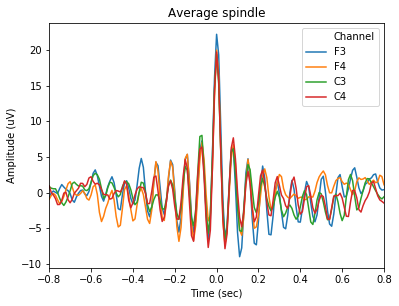

In [16]:
# To speed up the computation, we disable the bootstrap confidence intervals by specifying ci=None.
# For more details, please refer to the documentation of the seaborn.lineplot function at:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html
sp.plot_average(center='Peak', time_before=0.8, time_after=0.8, ci=None)

To get the actual peak-locked data underlying this figure, one can use the ``.get_sync_events`` method. The output is a long-format dataframe with the original data values centered around each detected spindles.

In [17]:
df_sync = sp.get_sync_events(center='Peak', time_before=0.8, time_after=0.8)
df_sync

,Time,Event,Amplitude,Channel,IdxChannel
0,-0.80,0,-9.274473,F3,0
1,-0.79,0,-6.832743,F3,0
2,-0.78,0,-4.507523,F3,0
3,-0.77,0,-3.998233,F3,0
4,-0.76,0,-8.483229,F3,0
...,...,...,...,...,...
30907,0.76,49,9.396885,C4,3
30908,0.77,49,6.334050,C4,3
30909,0.78,49,1.008784,C4,3
30910,0.79,49,-0.327676,C4,3
